In [1]:
import sys
sys.path.insert(1, '/Users/Andrew/Documents/PhD/Scripts/Python/pygplates_rev12')
import pygplates
import numpy as np
import glob
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid

%matplotlib inline

/Users/Andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def poles_of_rotation(to_time, from_time, delta_time,rotation_model, moving_plate, fixed_plate):

    #loop through a rotation in specific time intervals to extract poles of rotation

    #create variables
    Lats = []
    Longs = []
    Angles = []
    time_change = []
    
    for time in np.arange(to_time,from_time,delta_time):

        to_time = time
        from_time = time+delta_time
        stage_rotation = rotation_model.get_rotation(to_time,moving_plate,from_time,fixed_plate)

        pole_lat,pole_lon,pole_angle = stage_rotation.get_lat_lon_euler_pole_and_angle_degrees()

        #to make sure that all poles are expressed in the same hemisphere
        if pole_angle < 0:
            pole_lat = -1*pole_lat
            pole_lon = pole_lon-180
            pole_angle = -1*pole_angle


        time_change.append(from_time)
        #print 'Time interval = ',time,'-',time+delta_time,', Stage Pole Lat,Lon,Angle = %f,%f,%f ' % (pole_lat,pole_lon,pole_angle)
        Lats.append(pole_lat)
        Longs.append(pole_lon)
        Angles.append(np.radians(pole_angle))

    # These next lines are necessary becuase the answers come out in the northern hemisphere, 
    # need to check convention
    Longs = np.add(Longs,180.)
    Lats = np.multiply(Lats,-1)
    
    return Longs, Lats, Angles, time_change

In [3]:
def plotting_geometries(rotation_model, topology_features, time, delta_time):
    
    #extract geometries from a reconstructed file for plotting
    
    all_reconstructed_points = []
    all_velocities = []
    xy_reconstructed_points = []
    
    for feature in topology_features:

        # We need the feature's plate ID to get the equivalent stage rotation of that tectonic plate.
        domain_plate_id = feature.get_reconstruction_plate_id()

        # Get the rotation of plate 'domain_plate_id' from present day (0Ma) to 'reconstruction_time'.
        equivalent_total_rotation = rotation_model.get_rotation(time, domain_plate_id)

        # Get the rotation of plate 'domain_plate_id' from 'reconstruction_time + delta_time' to 'reconstruction_time'.
        equivalent_stage_rotation = rotation_model.get_rotation(time, domain_plate_id, time + delta_time)

        for geometry in feature.get_geometries():

            # Reconstruct the geometry to 'reconstruction_time'.
            reconstructed_geometry = equivalent_total_rotation * geometry
            reconstructed_points = reconstructed_geometry.get_points()
            xy_reconstructed_points = reconstructed_points.to_lat_lon_array()

            all_reconstructed_points.append(xy_reconstructed_points)

    poly_longs = []
    poly_lats = []
    for i in all_reconstructed_points:
        j = i[:,0]
        k = i[:,1]
        poly_longs.append(k)
        poly_lats.append(j)
        
    return poly_lats, poly_longs, all_reconstructed_points

In [8]:
#set some parameters up

#path to rotation file
pathDir = "/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/"

#specifiy rotations to use
files = glob.glob("{folder}/*AUSMEX.rot".format(folder=pathDir))

loaded_files = {}
for f in files:
    nice_name = f.split("/")[-1][14:-4]
    loaded_files[nice_name] = pygplates.RotationModel(os.path.join(pathDir, f))
    
    
#set path to topologies
input_topology_filename = '/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/Aus_Laur_3.gpml'

# Load the topological plate polygon features.
topology_features = pygplates.FeatureCollection(input_topology_filename)

#parameters
centre_longitude = 140
fixed_plate = 1001 #
moving_plate = 8004 #Australia (+Antarctica)
to_time = 650
from_time = 800
delta_time = 25

for rotation in loaded_files.keys():
    rotation_model = loaded_files[rotation]
    print rotation
    
date_line_wrapper = pygplates.DateLineWrapper(centre_longitude)

725-AUSMEX
775-AUSMEX
750-AUSMEX
800-AUSMEX


725-AUSMEX
[0.50106757649183364, 0.50106757649183009, 1.2316794739562178, 0.0, 0.0, 0.0]
[675, 725, 750]
775-AUSMEX
[0.50106757649183364, 0.50106757649183009, 0.4105598246520773, 0.41055982465207619, 0.41055982465208163, 0.0]
[675, 725, 800]
750-AUSMEX
[0.50106757649183364, 0.50106757649183009, 0.61583973697811267, 0.6158397369781119, 0.0, 0.0]
[675, 725, 775]
800-AUSMEX
[0.0, 0.0, 0.39889332115168685, 0.41900189956131173, 0.22790325033526609, 0.22790325033527392]
[725, 750, 775]


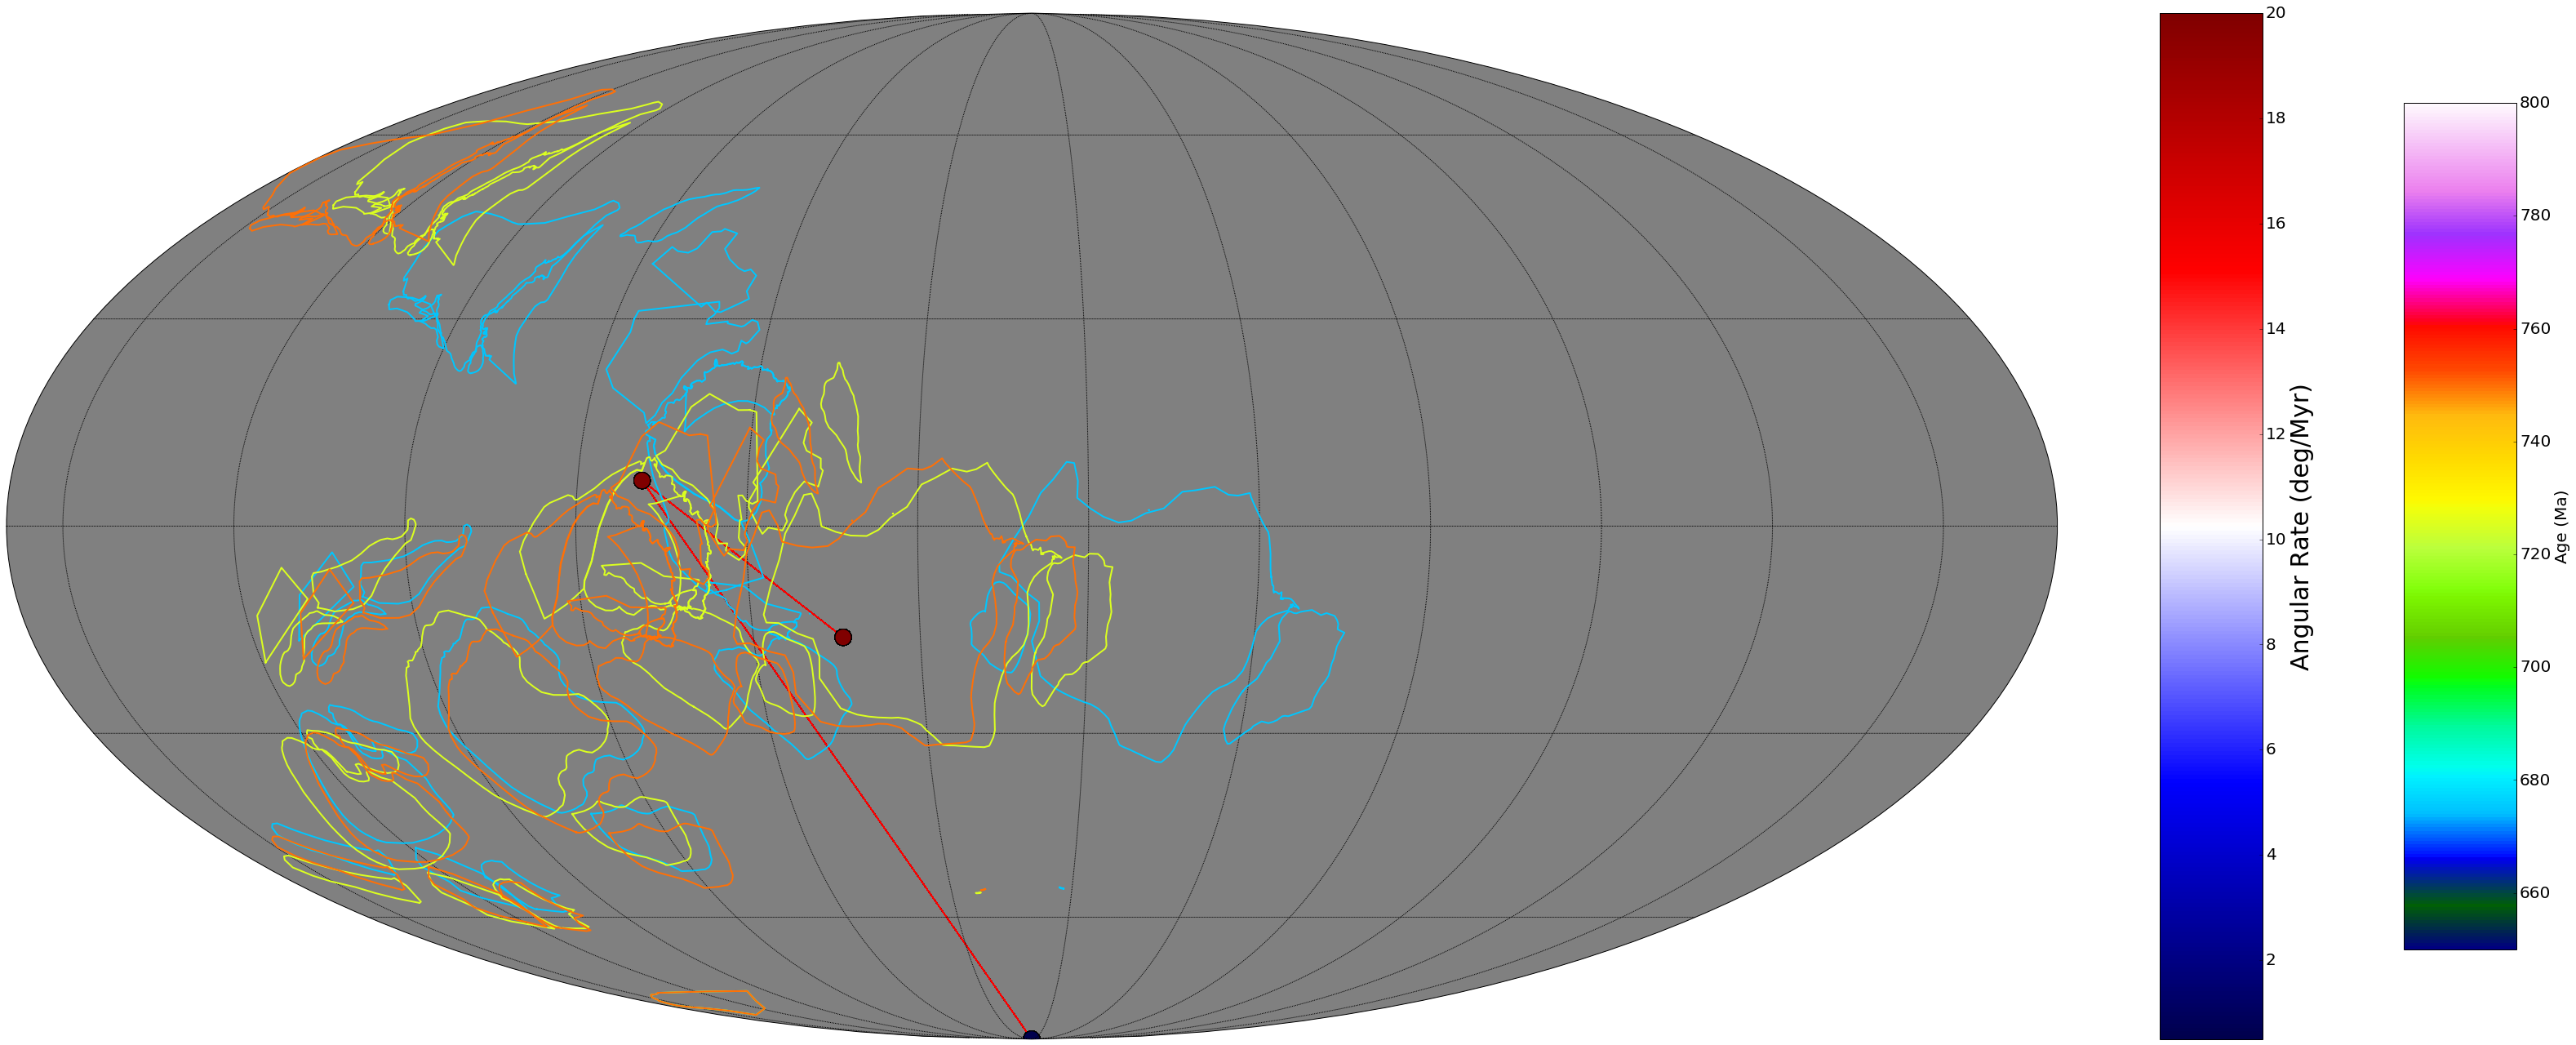

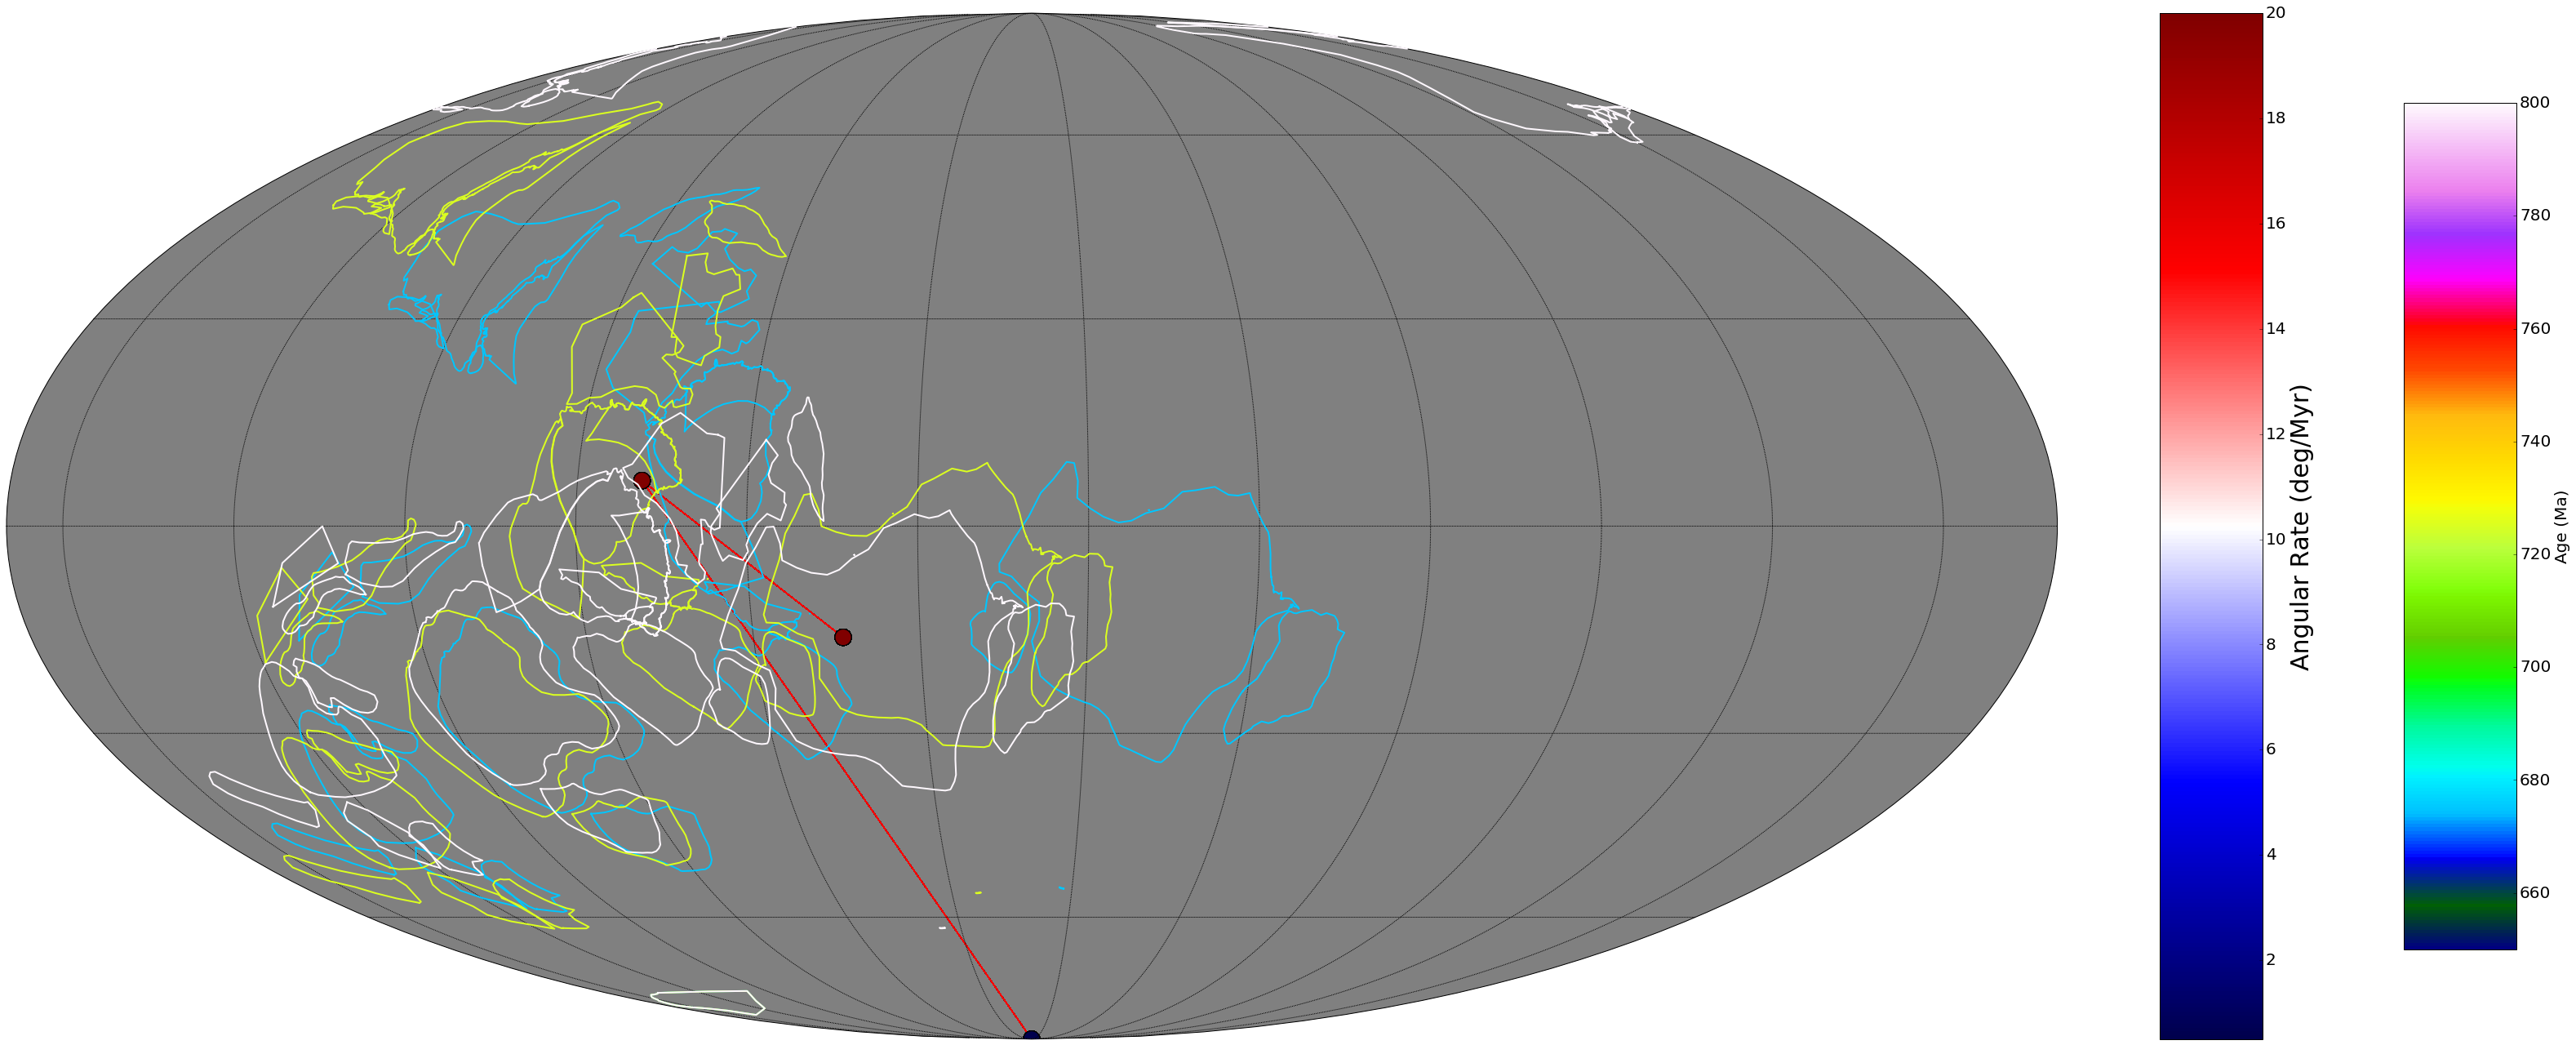

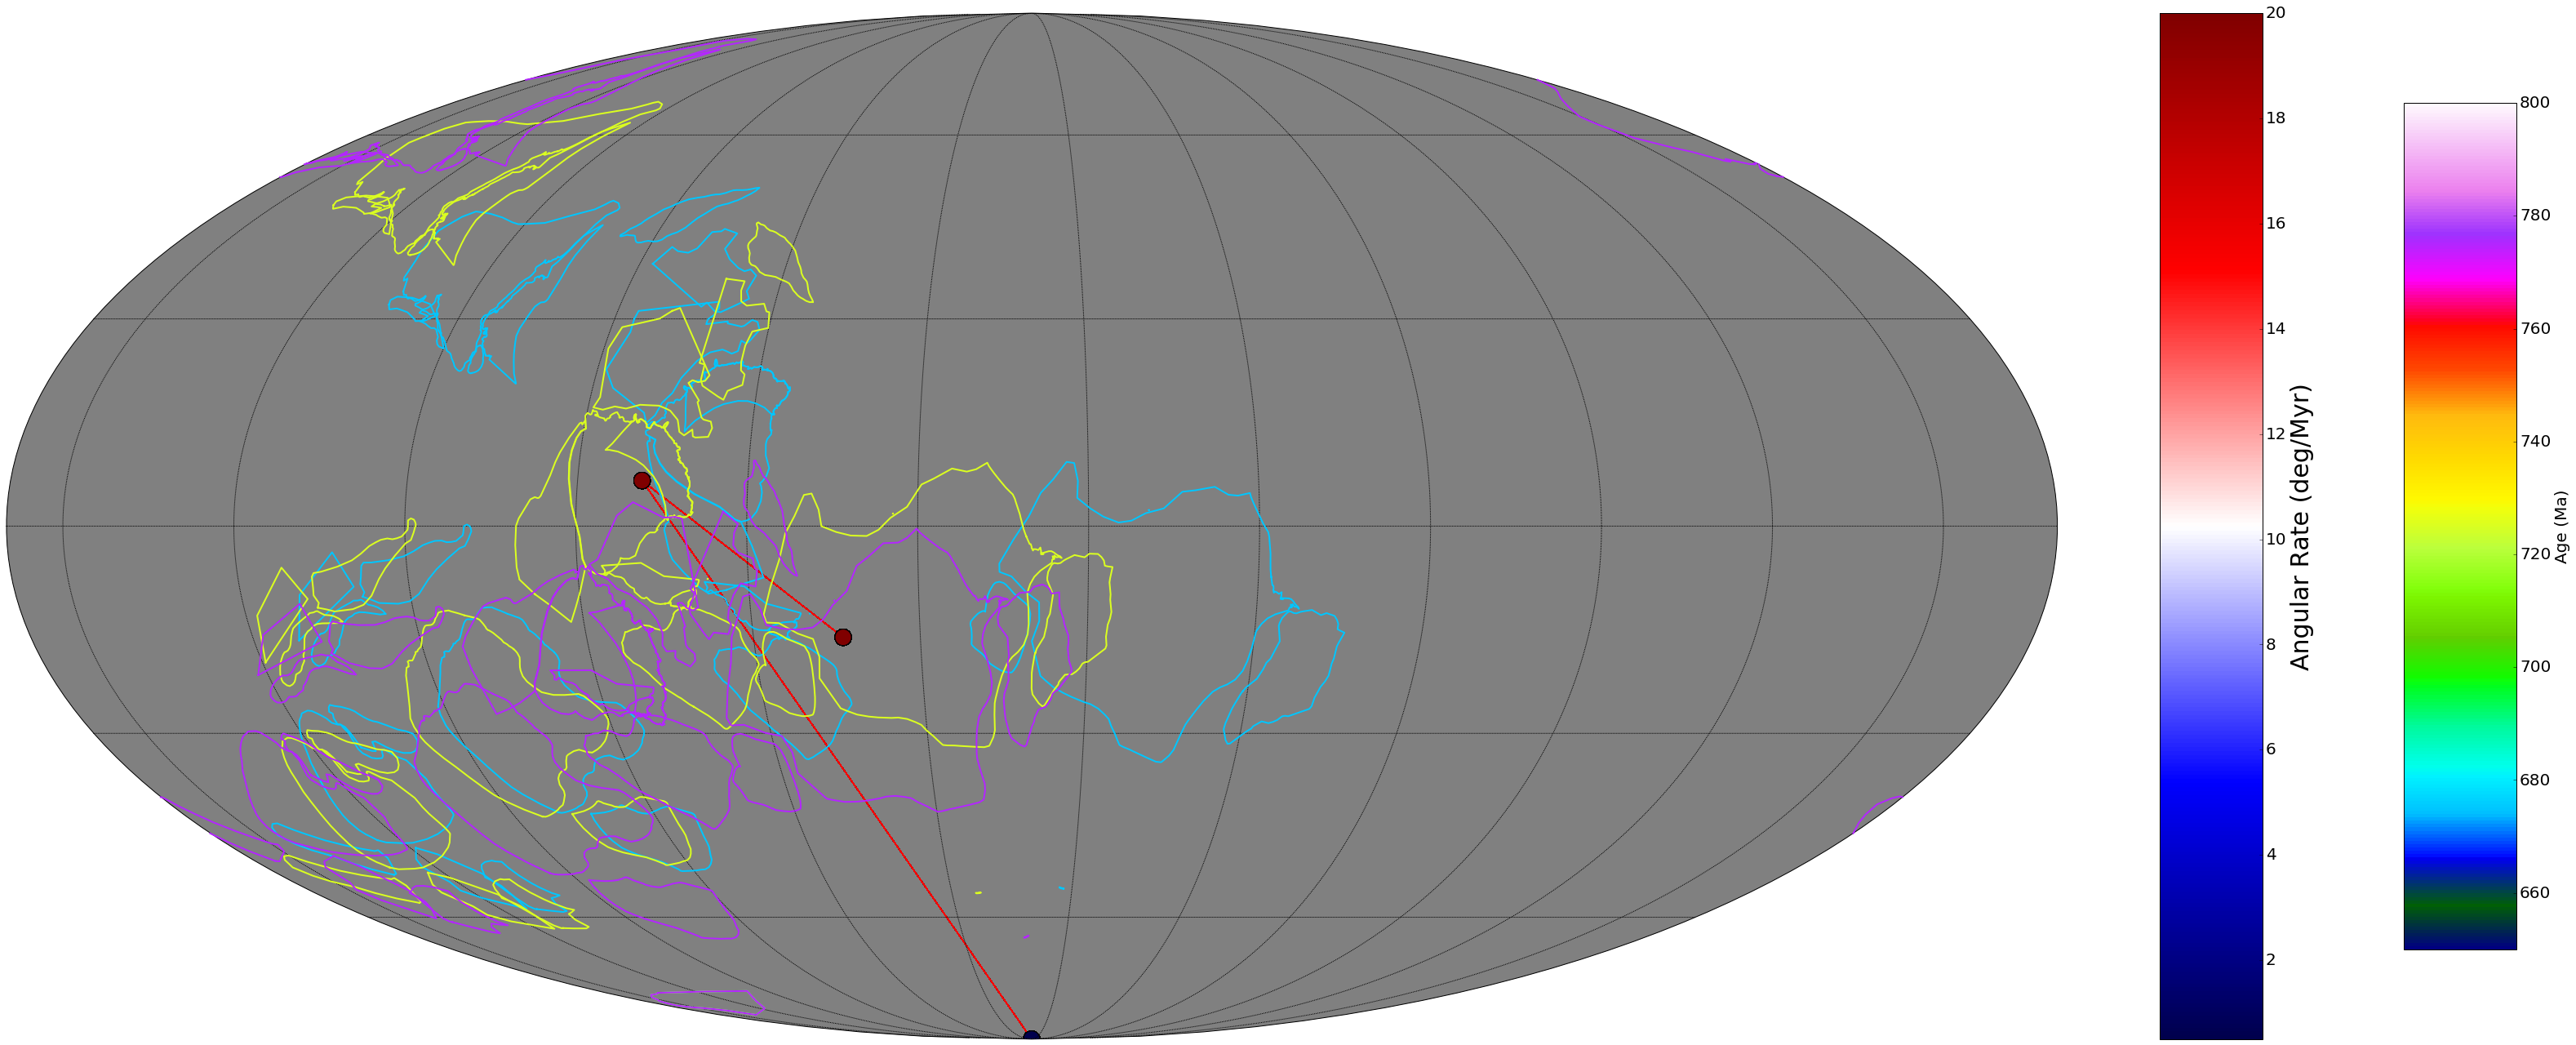

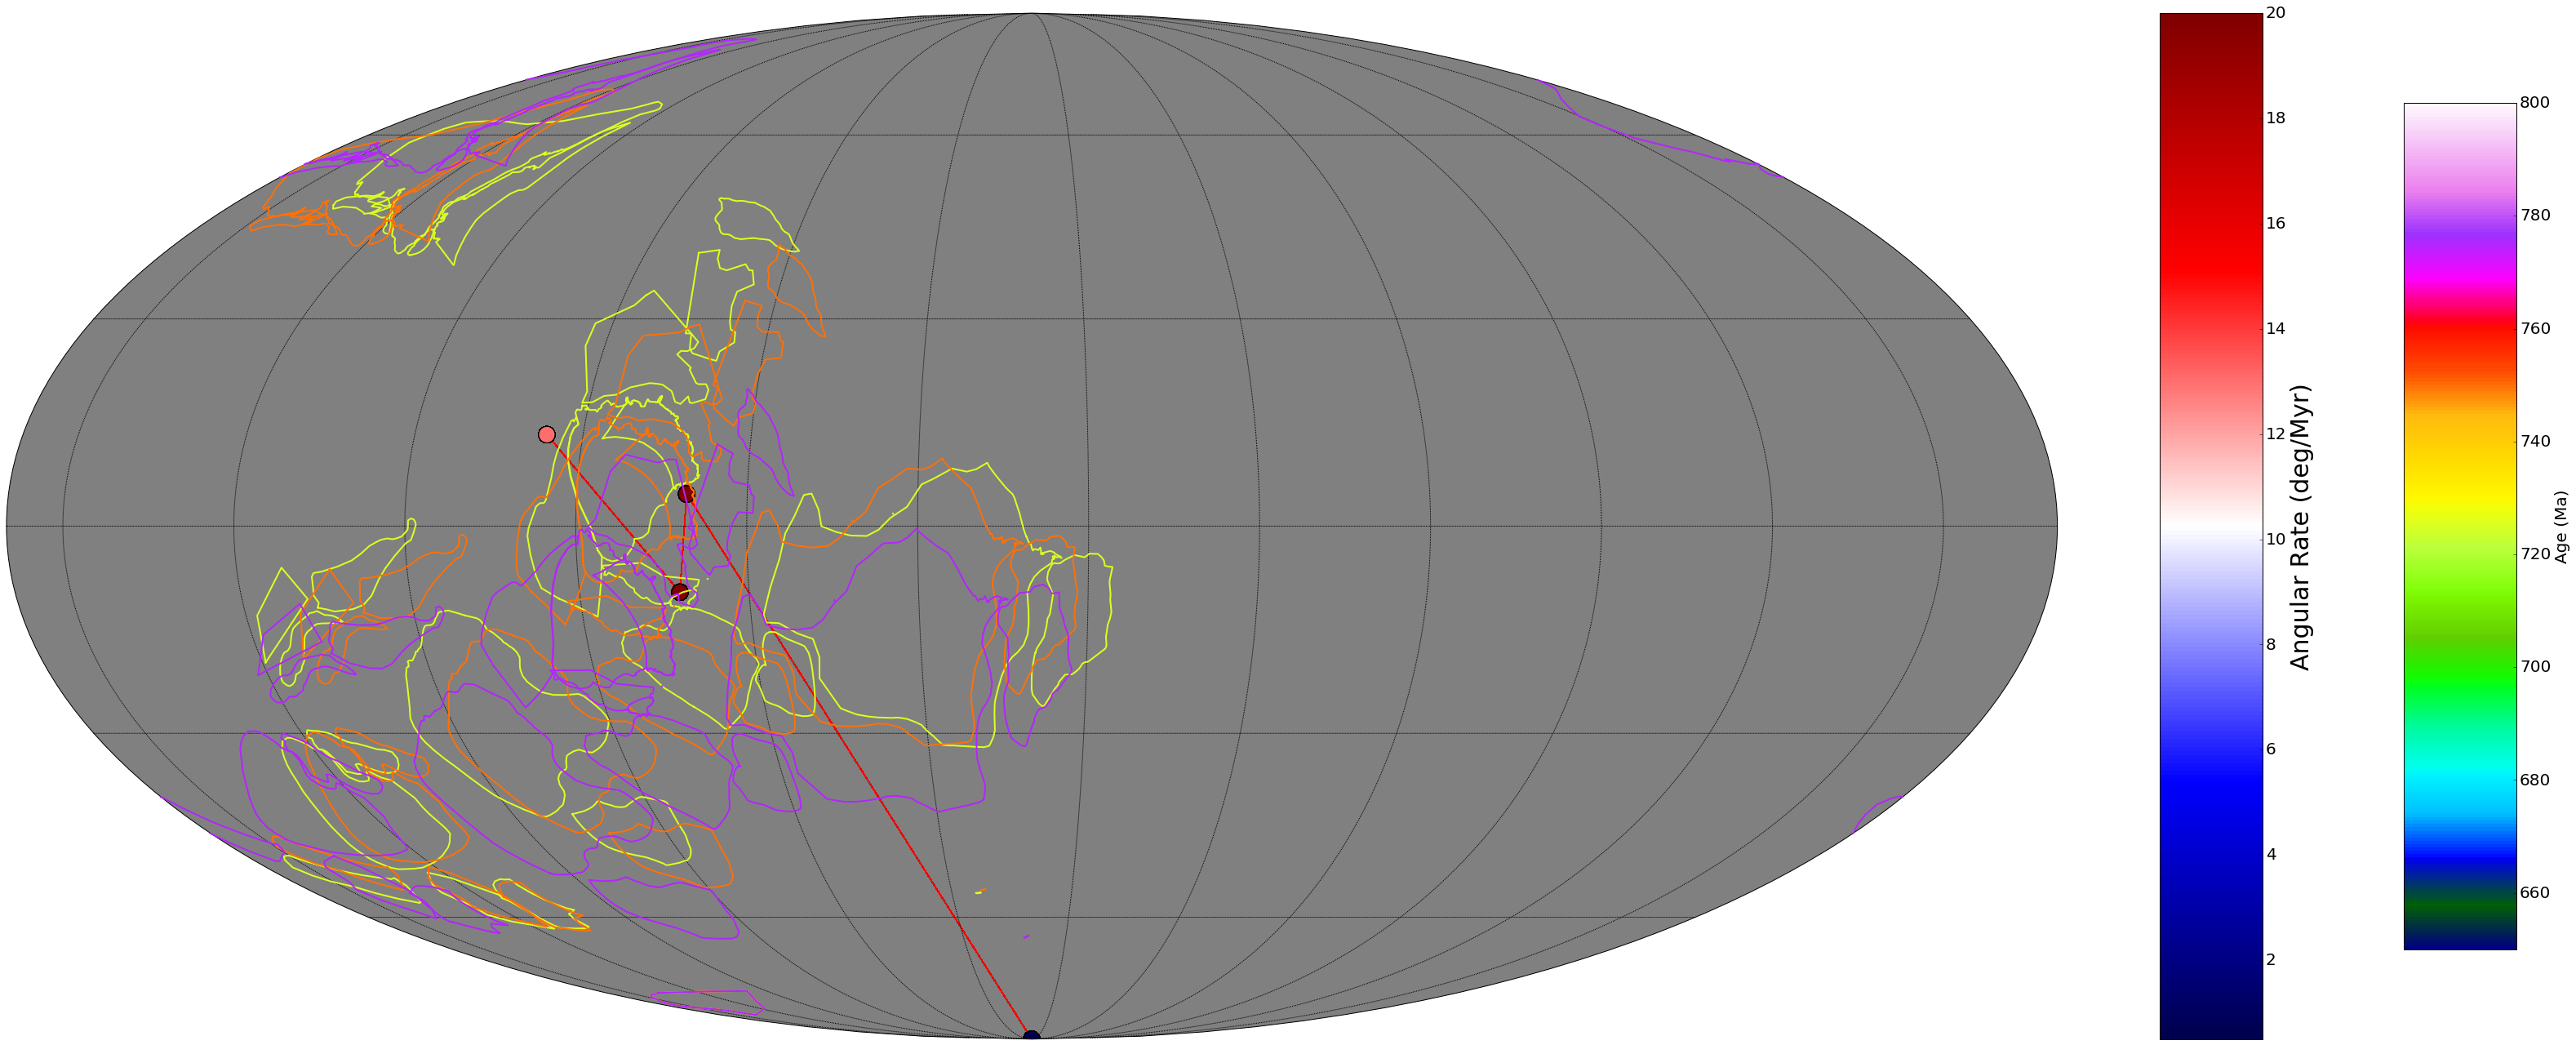

In [12]:
for rotation in loaded_files.keys():
    rotation_model = loaded_files[rotation]
    print rotation
    
    Longs, Lats, Angles, time_change = poles_of_rotation(to_time, from_time, delta_time, rotation_model, moving_plate, fixed_plate)
    
    print Angles
    
    times_to_plot = []
    prev_result = 0.
    for a, t in zip(Angles, time_change):
        if abs(prev_result - a) >= 1e-3 :
            times_to_plot.append(t)
        prev_result = a
    print times_to_plot
        
    fig = plt.figure(figsize=(48,24),dpi=30)
    ax_map = fig.add_axes([0,0,0.8,1.0])
    ax_cbr1 = fig.add_axes([0.85,0.2,0.04,.6])
    
    map_1 = Basemap(resolution='c',projection='moll',lon_0=centre_longitude, ax=ax_map)
    clip_path = map_1.drawmapboundary(fill_color='grey')
    map_1.drawmeridians(np.arange(0, 360, 30))
    map_1.drawparallels(np.arange(-90, 90, 30))

    cp = plt.cm.gist_ncar
    
    for time in times_to_plot:
        poly_lats, poly_longs, all_reconstructed_points = plotting_geometries(rotation_model, topology_features, time, delta_time)       
        for i, j in zip(poly_lats,poly_longs):
            latitudes = np.asarray(i)
            longitudes = np.asarray(j)
            polyline = pygplates.PolylineOnSphere(zip(latitudes, longitudes))
            wrapped_polylines = date_line_wrapper.wrap(polyline)
            for wrapped_polyline in wrapped_polylines:
                wrapped_points = wrapped_polyline.get_points()
                wrapped_points_lat = []
                wrapped_points_lon = []
                for wrapped_point in wrapped_points:
                    wrapped_point_lat, wrapped_point_lon = wrapped_point.get_latitude(), wrapped_point.get_longitude()
                    wrapped_points_lat.append(wrapped_point_lat)
                    wrapped_points_lon.append(wrapped_point_lon)
                    
                wrapped_points_lat = np.array(wrapped_points_lat)
                wrapped_points_lon = np.array(wrapped_points_lon)
                color = cp((to_time-time)/float(to_time-from_time))
                x_geom,y_geom = map_1(wrapped_points_lon, wrapped_points_lat)
                map_1.plot(x_geom, y_geom, color=color, linewidth=2)

            x,y = map_1(Longs,Lats)
            map_1.plot(x, y, 'r', clip_path=clip_path,zorder=0)
            l3=map_1.scatter(x, y, 400, c=np.degrees(Angles),
                    cmap=plt.cm.seismic,edgecolor='k',clip_path=clip_path,vmin=0.5,vmax=20)

    norm = mpl.colors.Normalize(vmin=from_time, vmax=to_time)
    cbar1 = mpl.colorbar.ColorbarBase(ax_cbr1, cmap=cp, norm=norm)
    cbar1.ax.tick_params(labelsize=20)
    cbar1.set_label('Age (Ma)', fontsize=20)
    
    cbar2 = map_1.colorbar(l3,location='right',pad="5%")
    cbar2.ax.tick_params(labelsize=20) 
    cbar2.set_label('Angular Rate (deg/Myr)',fontsize=30)

    #plt.savefig(os.path.join(results_dir, rotation), ext="png", transparent=True, bbox_inches='tight', pad_inches=1)
    # plt.show()

In [13]:
# Parameters required to define a flowline (as in GPlates)
SeedPoints = zip([-30],[115])
left_plate = 8004
right_plate = 1001
to_time1 = 0
times = np.arange(to_time1,from_time+1,10)     # using numpy to get a list of times in 1 Myr increments

In [14]:
# CREATE FLOWLINE
# POINTS ON THE FLOWLINE
multi_point = pygplates.MultiPointOnSphere(SeedPoints)

# Create the flowline feature
flowline_feature = pygplates.Feature.create_flowline(
    multi_point,
    times,
    valid_time=(np.max(times), np.min(times)),
    left_plate=left_plate,
    right_plate=right_plate)

In [15]:
# Load a rotation model (required to generate a synthetic flowline)
rotation_model = pygplates.RotationModel('/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/Aus-Laurentia_800-AUSWUS.rot')

# reconstruct the flowline - we want it in present day coordinates
reconstruction_time=650

# create an empty feature in which the reconstructed flowline geometries will be placed
reconstructed_flowlines = []


In [16]:
rotation_model

In [17]:
# call pygplates to generate the flowline feature
pygplates.reconstruct(flowline_feature, rotation_model, reconstructed_flowlines, reconstruction_time,
                      reconstruct_type=pygplates.ReconstructType.flowline)

In [18]:
times_2 = np.arange(reconstruction_time,from_time+1,10)

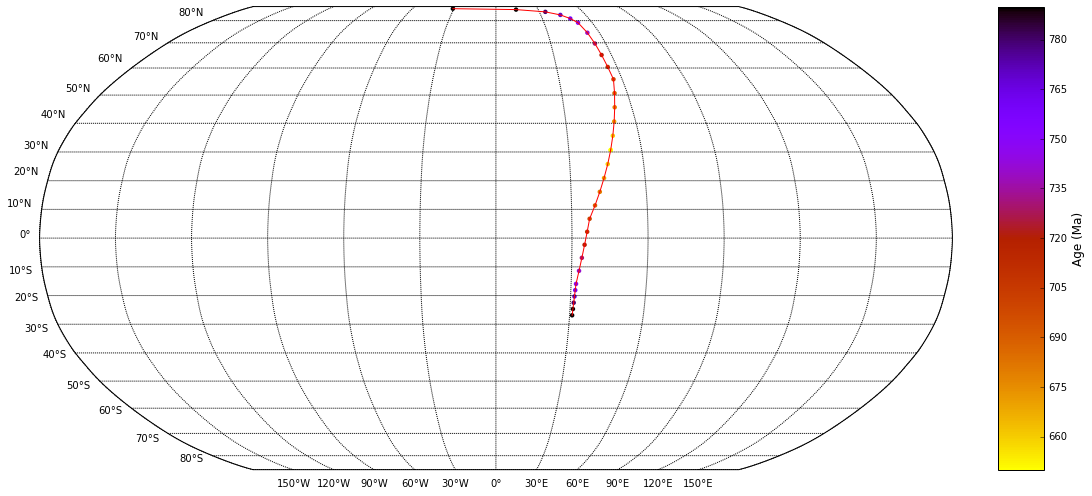

In [19]:
fig = plt.figure(figsize=(18,12),dpi=300)
map_2 = Basemap(resolution='c',projection='robin',lon_0=0.0)

clip_path = map_2.drawmapboundary(fill_color='white')
map_2.drawmeridians(np.arange(0, 360, 30),labels=[0,0,0,1],fontsize=10)
map_2.drawparallels(np.arange(-90, 90, 10), labels=[1,0,0,0],fontsize=10)

ax = plt.gca()

for reconstructed_flowline in reconstructed_flowlines:
    # Iterate over the left flowline points
    flowlinearray_left = np.empty([0,0])
    for left_point in reconstructed_flowline.get_left_flowline():
        flowlinearray_left = np.append(flowlinearray_left, left_point.to_lat_lon_array())
    # Iterate over the right flowline points
    flowlinearray_right = np.empty([0,0])
    for right_point in reconstructed_flowline.get_right_flowline():
        flowlinearray_right = np.append(flowlinearray_right, right_point.to_lat_lon_array())

    x,y = map_2(flowlinearray_left[1::2],flowlinearray_left[::2])
    l1,=map_2.plot(x, y, 'r', clip_path=clip_path,zorder=2)
    l3=map_2.scatter(x, y, 20, c=times_2,
                          cmap=plt.cm.gnuplot_r,
                     edgecolor='none', clip_path=clip_path,zorder=1,vmin=650,vmax=790)
    
    x,y = map_2(flowlinearray_right[1::2],flowlinearray_right[::2])
    map_2.plot(x, y, 'r', clip_path=clip_path,zorder=2)
    l3=map_2.scatter(x, y, 20, c=times_2,
                          cmap=plt.cm.gnuplot_r, edgecolor='none', clip_path=clip_path,zorder=1,vmin=650,vmax=790)
    
    cbar = map_2.colorbar(l3,location='right',pad="5%")
    cbar.set_label('Age (Ma)',fontsize=12)


plt.show()

In [20]:
# Iterate over all reconstructed flowlines.
# There will be two (one for each seed point).
for reconstructed_flowline in reconstructed_flowlines:

    # Print the flowline left/right plate IDs.
    print 'flowline: left %d, right %d at %fMa' % (
        reconstructed_flowline.get_feature().get_left_plate(),
        reconstructed_flowline.get_feature().get_right_plate(),
        reconstruction_time)

    # Print the reconstructed seed point location.
    print '  reconstructed seed point: lat: %f, lon: %f' % reconstructed_flowline.get_reconstructed_seed_point().to_lat_lon()

    flowline_times = reconstructed_flowline.get_feature().get_times()

    print '  left flowline:'

    # Iterate over the left points in the flowline.
    # The first point in the path is the youngest and the last point is the oldest.
    # So we reverse the order to start with the oldest.
    for point_index, left_point in enumerate(reversed(reconstructed_flowline.get_left_flowline())):

        lat, lon = left_point.to_lat_lon()

        # The first point in the path is the oldest and the last point is the reconstructed seed point.
        # So we need to start at the last time and work our way backwards.
        time = flowline_times[-1-point_index]

        # Print the point location and the time associated with it.
        print '    time: %f, lat: %f, lon: %f' % (time, lat, lon)

    print '  right flowline:'

    # Iterate over the right points in the flowline.
    # The first point in the path is the youngest and the last point is the oldest.
    # So we reverse the order to start with the oldest.
    for point_index, right_point in enumerate(reversed(reconstructed_flowline.get_right_flowline())):

        lat, lon = right_point.to_lat_lon()

        # The first point in the path is the oldest and the last point is the reconstructed seed point.
        # So we need to start at the last time and work our way backwards.
        time = flowline_times[-1-point_index]

        # Print the point location and the time associated with it.
        print '    time: %f, lat: %f, lon: %f' % (time, lat, lon)

flowline: left 8004, right 1001 at 650.000000Ma
  reconstructed seed point: lat: 30.696821, lon: 47.252583
  left flowline:
    time: 800.000000, lat: -26.879803, lon: 31.029842
    time: 790.000000, lat: -24.689624, lon: 31.192716
    time: 780.000000, lat: -22.500328, lon: 31.366547
    time: 770.000000, lat: -20.311993, lon: 31.551292
    time: 760.000000, lat: -18.124702, lon: 31.746993
    time: 750.000000, lat: -15.938540, lon: 31.953776
    time: 740.000000, lat: -11.400505, lon: 32.971722
    time: 730.000000, lat: -6.863086, lon: 33.976370
    time: 720.000000, lat: -2.327678, lon: 34.980654
    time: 710.000000, lat: 2.204303, lon: 35.997115
    time: 700.000000, lat: 6.731347, lon: 37.038522
    time: 690.000000, lat: 11.389039, lon: 39.315182
    time: 680.000000, lat: 16.124547, lon: 41.455925
    time: 670.000000, lat: 20.926995, lon: 43.480509
    time: 660.000000, lat: 25.787086, lon: 45.407064
    time: 650.000000, lat: 30.696821, lon: 47.252583
  right flowline:
    t

In [21]:
#loop through rotation file to extract poles and angles of rotation

#set up results file
script_dir = os.path.dirname("__file__")
results_dir = os.path.join(script_dir, 'Results/Angular_Rate/', rotation[4:])
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
    
for rotation in loaded_files.keys():
    rotation_model = loaded_files[rotation]
    print rotation

    sample_file_name = rotation
    
    Longs, Lats, Angles = poles_of_rotation(to_time, from_time, delta_time, rotation_model, moving_plate, fixed_plate)

    # Make the figure and a dummy orthographic map to get extents
    fig = plt.figure(figsize=(48,24),dpi=30)
    lat_0=0. ; lon_0=180.
    m1 = Basemap(projection='moll',lon_0=lon_0,lat_0=lat_0,resolution=None)

    # Second subplot
    ax = fig.add_axes([0.5,0.1,0.5,0.8],axisbg='k')
    pmap = Basemap(projection='moll',lon_0=lon_0,lat_0=lat_0,resolution='l')#,\
    #     llcrnrx=m1.urcrnrx/-6.,llcrnry=m1.urcrnry/-6.,urcrnrx=m1.urcrnrx/6.,urcrnry=m1.urcrnry/6.)
    clip_path = pmap.drawmapboundary(fill_color='white')
    pmap.fillcontinents(color='grey', lake_color='white', zorder=0)
    pmap.drawmeridians(np.arange(0, 360, 30))
    pmap.drawparallels(np.arange(-90, 90, 30))
    ax = plt.gca()

    x,y = pmap(Longs,Lats)
    pmap.plot(x, y, 'r', clip_path=clip_path,zorder=0)
    l3=pmap.scatter(x, y, 400, c=np.degrees(Angles),
                cmap=plt.cm.jet_r,edgecolor='k',clip_path=clip_path,vmin=0.5,vmax=20)

    cbar = pmap.colorbar(l3,location='right',pad="5%")
    cbar.ax.tick_params(labelsize=10) 
    cbar.set_label('Angular Rate (deg/Myr)',fontsize=20)
    
    plt.savefig(os.path.join(results_dir, rotation), ext="png", transparent=True, bbox_inches='tight', pad_inches=1)
    plt.show()

725-AUSMEX


ValueError: too many values to unpack

In [ ]:
#loop through rotation file to extract poles and angles of rotation

#set up results file
#script_dir = os.path.dirname("__file__")
#results_dir = os.path.join(script_dir, 'Results/Euler_pole/', rotation[4:])
#if not os.path.isdir(results_dir):
#    os.makedirs(results_dir)
    
#loop through rotations    
for rotation in loaded_files.keys():
    rotation_model = loaded_files[rotation]
    print rotation

#    sample_file_name = rotation
    Longs, Lats, Angles = poles_of_rotation(to_time, from_time, delta_time, rotation_model, moving_plate, fixed_plate)
    
    
    # Make the figure and a dummy orthographic map to get extents
    fig = plt.figure(figsize=(48,24),dpi=30)
    lat_0=0. ; lon_0=180.
    m1 = Basemap(projection='moll',lon_0=lon_0,lat_0=lat_0,resolution=None)
    ax = fig.add_axes([0.0,0.1,0.5,0.8],axisbg='k')
    pmap = Basemap(projection='moll',lon_0=lon_0,lat_0=lat_0,resolution='l')#,\
                   
    clip_path = pmap.drawmapboundary(fill_color='white')
    pmap.fillcontinents(color='grey', lake_color='white', zorder=0)
    pmap.drawmeridians(np.arange(0, 360, 30))
    pmap.drawparallels(np.arange(-90, 90, 30))
    ax = plt.gca()

    x,y = pmap(Longs,Lats)
    pmap.plot(x, y, 'r', clip_path=clip_path,zorder=0)
    l3=pmap.scatter(x, y, 400, c=np.arange(650,800,delta_time),
                cmap=plt.cm.jet_r,edgecolor='k',clip_path=clip_path,vmin=650,vmax=800)

    cbar = pmap.colorbar(l3,location='right',pad="5%")
    cbar.ax.tick_params(labelsize=30) 
    cbar.set_label('Time (Ma)',fontsize=40)
    plt.title(('Euler pole', rotation), fontsize=20)

    #plt.savefig(os.path.join(results_dir, rotation), ext="png", transparent=True, bbox_inches='tight', pad_inches=1)
    #plt.show()